<a href="https://colab.research.google.com/github/yubin0727/captcha_recognition/blob/main/Captcha_plot_delete_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# gpu 사용
!nvidia-smi

Wed Nov 30 11:03:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

np.random.seed(42)

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1006


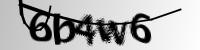

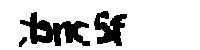

['b' 'n' 'c' '5' 'f']


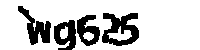

['w' 'g' '6' '2' '5']


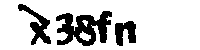

['x' '3' '8' 'f' 'n']


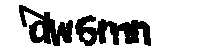

['d' 'w' '6' 'm' 'n']


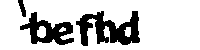

['b' 'e' 'f' 'b' 'd']
(1006, 50, 200, 1)


In [3]:
# 샘플 이미지 출력
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

# 이미지 크기, 채널
data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)

characters = []

for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE)
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((4, 3), np.uint8)) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  image = np.reshape(image, (data_height, data_width, n_channel)) 
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[15] * 255)
print(label[15])
cv2_imshow(images[55] * 255)
print(label[55])
cv2_imshow(images[225] * 255)
print(label[225])
cv2_imshow(images[500] * 255)
print(label[500])
cv2_imshow(images[750] * 255)
print(label[750])
print(images.shape)

In [4]:
from string import ascii_lowercase, digits

# 글자 종류 확인
characters = list(set(characters))
characters.sort()
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


(1006, 5)
[258, 256, 276, 275, 251, 250, 258, 237, 257, 248, 229, 262, 263, 269, 515, 248, 228, 261, 189]


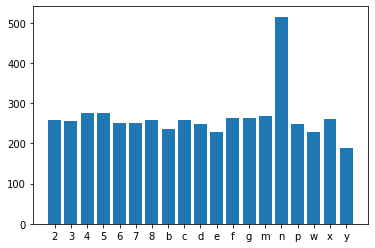

In [5]:
import matplotlib.pyplot as plt

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None

character_num = [0] * len(characters)

print(label.shape)
for i in range(len(label)):
  for j in range(len(label[0])):
    character_num[char_to_num(label[i,j])] += 1
print(character_num)

x = np.arange(len(characters))
plt.bar(x, character_num)
plt.xticks(x, characters)

plt.show()

In [6]:
# 원핫인코딩    
num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [7]:
import random

index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

# train, test split by index
for i in range(len_data):
  train_X, test_X = images[index_list[:900]], images[index_list[900:]]
  train_y, test_y = num_label[:,index_list[:900]], num_label[:,index_list[900:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[465  43 570 ... 204 149  33]
900 106
(900, 50, 200, 1)
900 106
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import layers

In [9]:
def create_model(num_classes):
    img = layers.Input(shape=(50, 200, 1)) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (4, 4), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (4, 4), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (4, 4), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_classes, activation='sigmoid')(drop)
        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [10]:
num_classes = len(characters)
model = create_model(num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  272         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  8224        ['max_pooling2d[0][0]']      

In [11]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
23/23 [==============================] - 5s 48ms/step - loss: 15.3367 - dense_1_loss: 3.0560 - dense_3_loss: 3.0538 - dense_5_loss: 3.0672 - dense_7_loss: 3.1136 - dense_9_loss: 3.0461 - dense_1_accuracy: 0.0764 - dense_3_accuracy: 0.0847 - dense_5_accuracy: 0.0722 - dense_7_accuracy: 0.0486 - dense_9_accuracy: 0.0722 - val_loss: 14.7165 - val_dense_1_loss: 2.9400 - val_dense_3_loss: 2.9494 - val_dense_5_loss: 2.9412 - val_dense_7_loss: 2.9461 - val_dense_9_loss: 2.9398 - val_dense_1_accuracy: 0.1000 - val_dense_3_accuracy: 0.0778 - val_dense_5_accuracy: 0.0556 - val_dense_7_accuracy: 0.0611 - val_dense_9_accuracy: 0.1056
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 14.5898 - dense_1_loss: 2.8979 - dense_3_loss: 2.9290 - dense_5_loss: 2.9370 - dense_7_loss: 2.9242 - dense_9_loss: 2.9018 - dense_1_accuracy: 0.0861 - dense_3_accuracy: 0.0792 - dense_5_accuracy: 0.0861 - dense_7_accuracy: 0.1028 - dense_9_accuracy: 0.0736 - val_loss: 14.6834 - val_

In [12]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [13]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [14]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 16ms/step
0.7355555555555555
900


In [15]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

1/1 [==============================] - 0s 15ms/step
47e4p
47e4p


In [16]:
print(hist.history.keys())

dict_keys(['loss', 'dense_1_loss', 'dense_3_loss', 'dense_5_loss', 'dense_7_loss', 'dense_9_loss', 'dense_1_accuracy', 'dense_3_accuracy', 'dense_5_accuracy', 'dense_7_accuracy', 'dense_9_accuracy', 'val_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_5_loss', 'val_dense_7_loss', 'val_dense_9_loss', 'val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy'])


0.0763888880610466 0.08472222089767456 0.07222222536802292 0.0486111119389534 0.07222222536802292
100
0.10000000149011612 0.07777778059244156 0.0555555559694767 0.06111111119389534 0.10555555671453476
100
0.0800000011920929


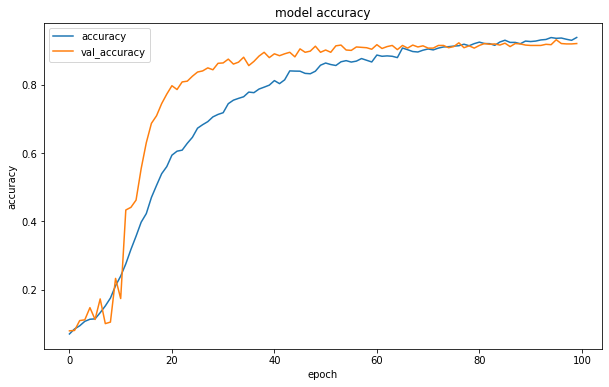

In [17]:
import matplotlib.pyplot as plt
n_epoch = 100
acc = np.zeros((5, n_epoch))
val_acc = np.zeros((5, n_epoch))
accuracy = []
val_accuracy = []
acc[0, :] = hist.history['dense_1_accuracy']
acc[1, :] = hist.history['dense_3_accuracy']
acc[2, :] = hist.history['dense_5_accuracy']
acc[3, :] = hist.history['dense_7_accuracy']
acc[4, :] = hist.history['dense_9_accuracy']
print(acc[0, 0], acc[1, 0], acc[2, 0], acc[3, 0], acc[4, 0])
for i in range(n_epoch):
  ave = (acc[0, i] + acc[1, i] + acc[2, i] + acc[3, i] + acc[4, i]) / 5
  accuracy.append(ave)
print(len(accuracy))

val_acc[0, :] = hist.history['val_dense_1_accuracy']
val_acc[1, :] = hist.history['val_dense_3_accuracy']
val_acc[2, :] = hist.history['val_dense_5_accuracy']
val_acc[3, :] = hist.history['val_dense_7_accuracy']
val_acc[4, :] = hist.history['val_dense_9_accuracy']
print(val_acc[0, 0], val_acc[1, 0], val_acc[2, 0], val_acc[3, 0], val_acc[4, 0])
for i in range(n_epoch):
  ave = (val_acc[0, i] + val_acc[1, i] + val_acc[2, i] + val_acc[3, i] + val_acc[4, i]) / 5
  val_accuracy.append(ave)
print(len(val_accuracy))
print(val_accuracy[0])

plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

3.0560107231140137 3.053802490234375 3.0671989917755127 3.113572835922241 3.046111822128296
100
3.067339372634888
2.939974308013916 2.9494237899780273 2.941230297088623 2.946068286895752 2.939802408218384
100
2.9432998180389403


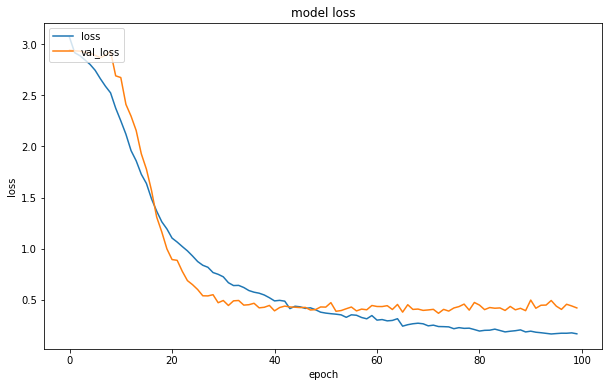

In [18]:
loss = np.zeros((5, n_epoch))
val_loss = np.zeros((5, n_epoch))
loss_ave = []
val_loss_ave = []
loss[0, :] = hist.history['dense_1_loss']
loss[1, :] = hist.history['dense_3_loss']
loss[2, :] = hist.history['dense_5_loss']
loss[3, :] = hist.history['dense_7_loss']
loss[4, :] = hist.history['dense_9_loss']
print(loss[0, 0], loss[1, 0], loss[2, 0], loss[3, 0], loss[4, 0])
for i in range(n_epoch):
  ave = (loss[0, i] + loss[1, i] + loss[2, i] + loss[3, i] + loss[4, i]) / 5
  loss_ave.append(ave)
print(len(loss_ave))
print(loss_ave[0])

val_loss[0, :] = hist.history['val_dense_1_loss']
val_loss[1, :] = hist.history['val_dense_3_loss']
val_loss[2, :] = hist.history['val_dense_5_loss']
val_loss[3, :] = hist.history['val_dense_7_loss']
val_loss[4, :] = hist.history['val_dense_9_loss']
print(val_loss[0, 0], val_loss[1, 0], val_loss[2, 0], val_loss[3, 0], val_loss[4, 0])
for i in range(n_epoch):
  ave = (val_loss[0, i] + val_loss[1, i] + val_loss[2, i] + val_loss[3, i] + val_loss[4, i]) / 5
  val_loss_ave.append(ave)
print(len(val_loss_ave))
print(val_loss_ave[0])

plt.figure(figsize=(10, 6))
plt.plot(loss_ave, label='training loss')
plt.plot(val_loss_ave, label='validation loss')
plt.legend(['loss', 'val_loss'], loc = 'upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predictresult = predict_x(train_X[i])
  realresult = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
    if (predictresult[j] == "m") and (realresult[j] == "n"):
      index.append(i)

print("n을 m으로 misclassification: " + str(len(index)))

1/1 [==============================] - 0s 15ms/step
n을 m으로 misclassification: 50


0.9355555555555556
0.9393563532430844
0.9421434558880405
0.9393563532430844
0.9373890148636999
(19, 19)


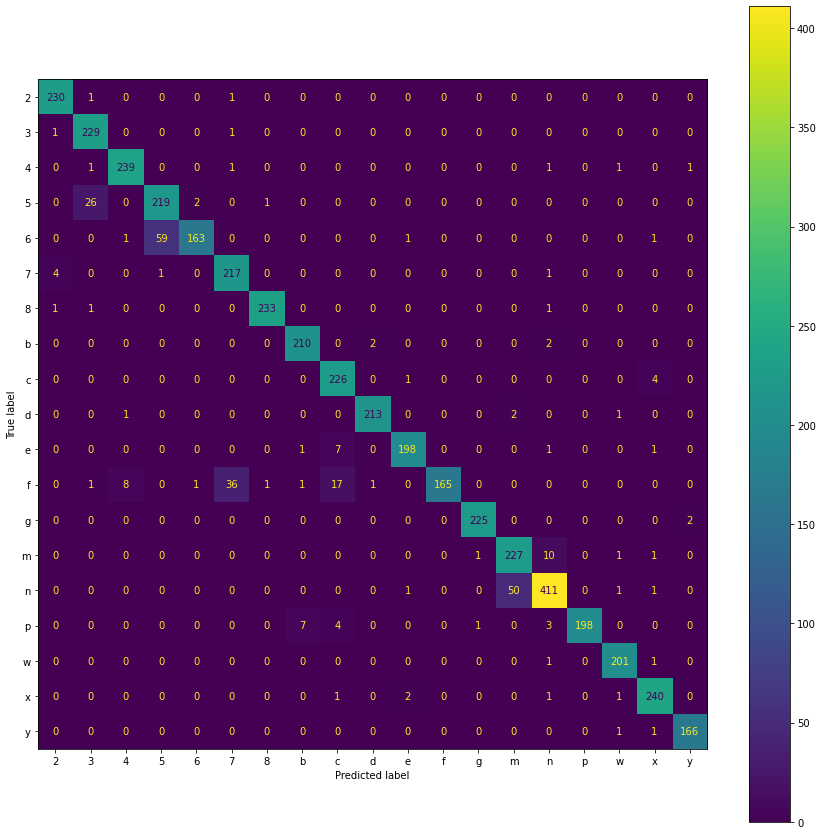

In [20]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

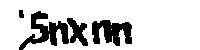

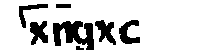

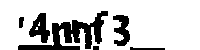

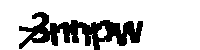

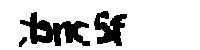

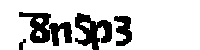

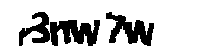

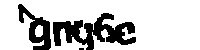

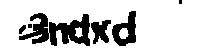

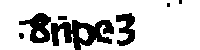

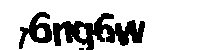

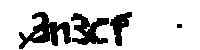

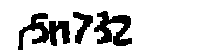

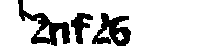

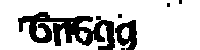

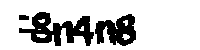

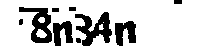

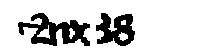

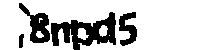

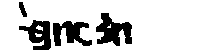

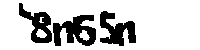

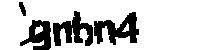

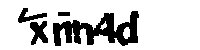

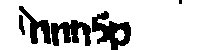

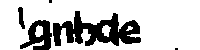

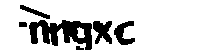

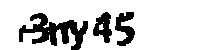

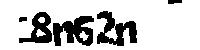

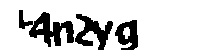

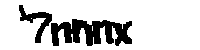

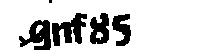

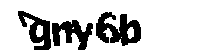

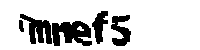

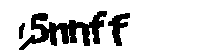

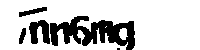

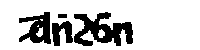

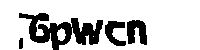

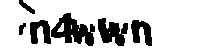

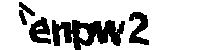

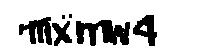

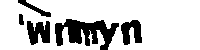

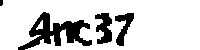

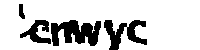

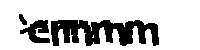

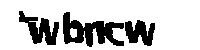

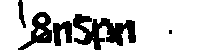

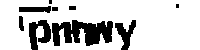

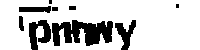

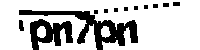

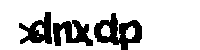

In [21]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)